# Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import random

# Setting Device

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

cuda


# 1. Data Transformations

In [4]:
num_epochs = 40
batchsize = 1
classes = ('0','1','2','3','4')

### a. No Transformation on Input Images

In [5]:
transform_bunch = transforms.Compose([
  transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder("/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images", transform_bunch)

train_size = int(0.8 * len(dataset))  # 80% for training, adjust as needed
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

num_epochs = 40
batchsize = 1
classes = ('0','1','2','3','4')

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset , batch_size=batchsize, shuffle=False)

### b. Gaussian Filter

In [6]:
transform_bunch = transforms.Compose([
  transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder("/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images", 
                                           transform_bunch)

train_size = int(0.8 * len(dataset))  # 80% for training, adjust as needed
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

gaussian_train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True)
gaussian_test_loader = torch.utils.data.DataLoader(dataset=test_dataset , batch_size=batchsize, shuffle=False)

### c. Histogram Equalisation

In [7]:
transform_bunch = transforms.Compose([
    transforms.RandomEqualize(p=1),
    transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder("/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images", 
                                           transform_bunch)

train_size = int(0.8 * len(dataset))  # 80% for training, adjust as needed
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

equi_train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True)
equi_test_loader = torch.utils.data.DataLoader(dataset=test_dataset , batch_size=batchsize, shuffle=False)

### d. Grayscale

In [8]:
transform_bunch = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder("/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images", 
                                           transform_bunch)

train_size = int(0.8 * len(dataset))  # 80% for training, adjust as needed
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

grayscale_train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True)
grayscale_test_loader = torch.utils.data.DataLoader(dataset=test_dataset , batch_size=batchsize, shuffle=False)

### e. Center-Crop

In [ ]:
transform_bunch = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder("/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images", 
                                           transform_bunch)

train_size = int(0.8 * len(dataset))  # 80% for training, adjust as needed
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

center_cropped_train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True)
center_cropped_test_loader = torch.utils.data.DataLoader(dataset=test_dataset , batch_size=batchsize, shuffle=False)

### f. Data Augmentation

In [9]:
from torch.utils.data import ConcatDataset, Dataset

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

transform_bunch = transforms.Compose([
    transforms.ToTensor()
])

# Load original dataset
original_dataset = torchvision.datasets.ImageFolder("/kaggle/input/diabetic-retinopathy-224x224-2019-data/colored_images", transform=transforms.ToTensor())

# Initialize a list to store augmented images
augmented_images = []

# Augment each image in the original dataset and add to the list
for image, label in original_dataset:
    augmented_images.append((image, label))
    augmented_images.append((transforms.functional.hflip(image), label))  # Horizontal flip
    augmented_images.append((transforms.functional.vflip(image), label))  # Vertical flip

# Create a new dataset with augmented images
augmented_dataset = CustomDataset(augmented_images)

# Concatenate the original dataset with the augmented dataset twice
dataset = ConcatDataset([augmented_dataset])

print(len(dataset))
train_size = int(0.8 * len(dataset))  # 80% for training, adjust as needed
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

augmented_train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True)
augmented_test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batchsize, shuffle=False)

10986


# 2. Data Visualization

In [11]:
def show_images(images, labels, cm="", ncols=4):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        # Plot image
        img = np.transpose(images[i].numpy(), (1, 2, 0))  # Convert tensor to numpy array
        if cm == "gray":
            ax.imshow(img, cm)
        else:
            ax.imshow(img)
        ax.set_title(f'Label: {classes[labels[i].item()]}')
        ax.axis('off')
    plt.show()

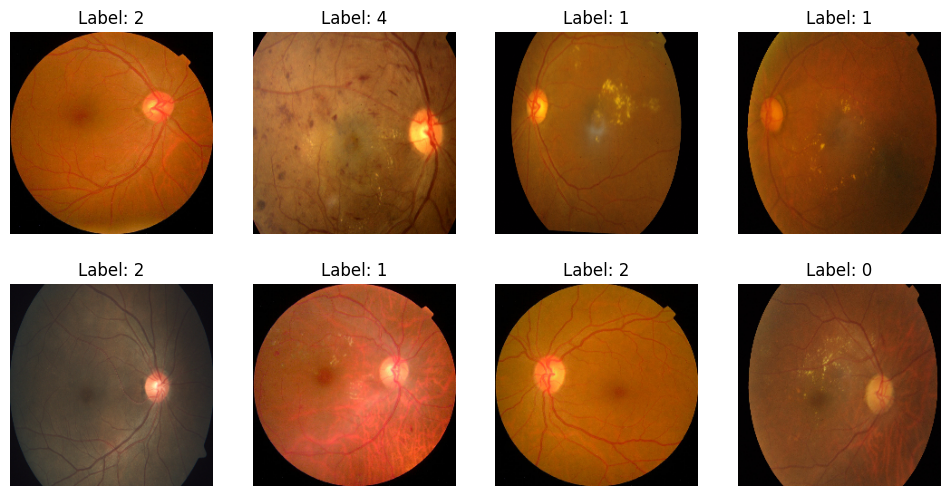

In [12]:
images = []
labels = []
for _ in range(8):
    images1, labels1 = next(iter(train_loader))
    images.append(images1[0])
    labels.append(labels1[0])

show_images(images, labels)

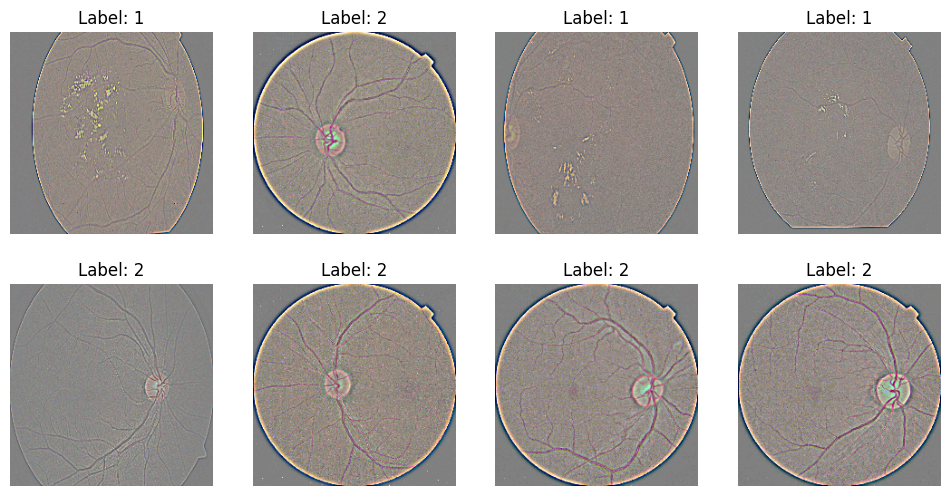

In [13]:
images = []
labels = []
for _ in range(8):
    images1, labels1 = next(iter(gaussian_train_loader))
    images.append(images1[0])
    labels.append(labels1[0])

show_images(images, labels)

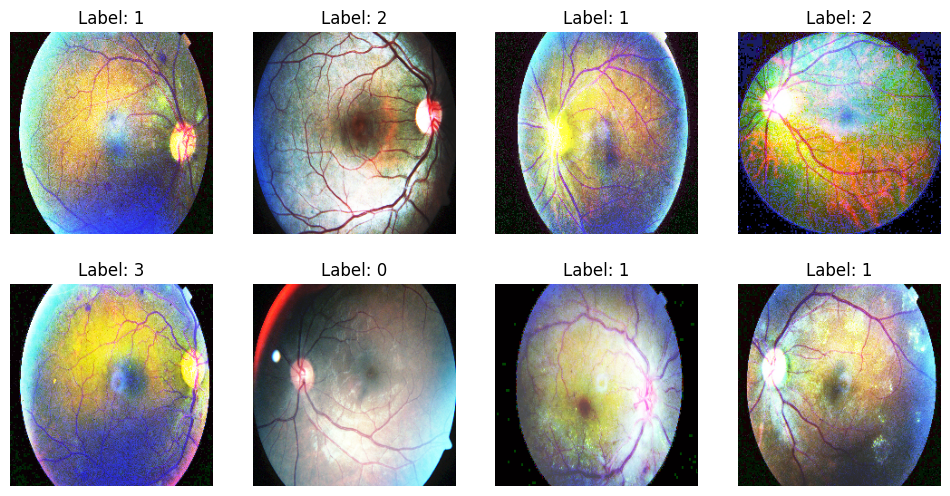

In [14]:
images = []
labels = []
for _ in range(8):
    images1, labels1 = next(iter(equi_train_loader))
    images.append(images1[0])
    labels.append(labels1[0])

show_images(images, labels)

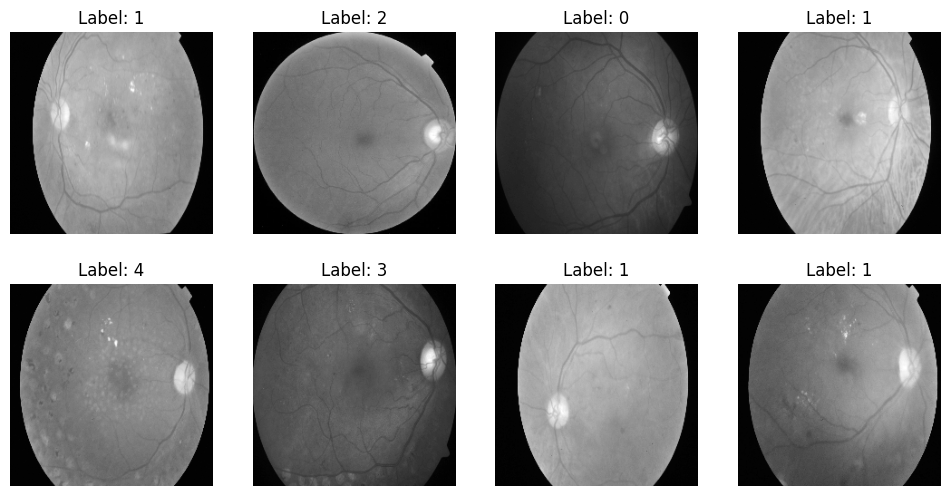

In [15]:
images = []
labels = []
for _ in range(8):
    images1, labels1 = next(iter(grayscale_train_loader))
    images.append(images1[0])
    labels.append(labels1[0])

show_images(images, labels, cm="gray")

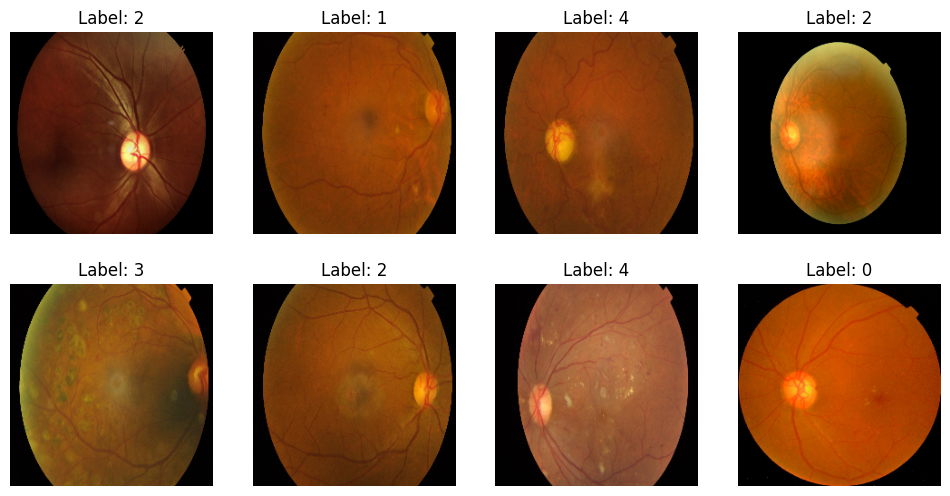

In [ ]:
images = []
labels = []
for _ in range(8):
    images1, labels1 = next(iter(center_cropped_train_loader))
    labels.append(labels1[0])  


show_images(images, labels)


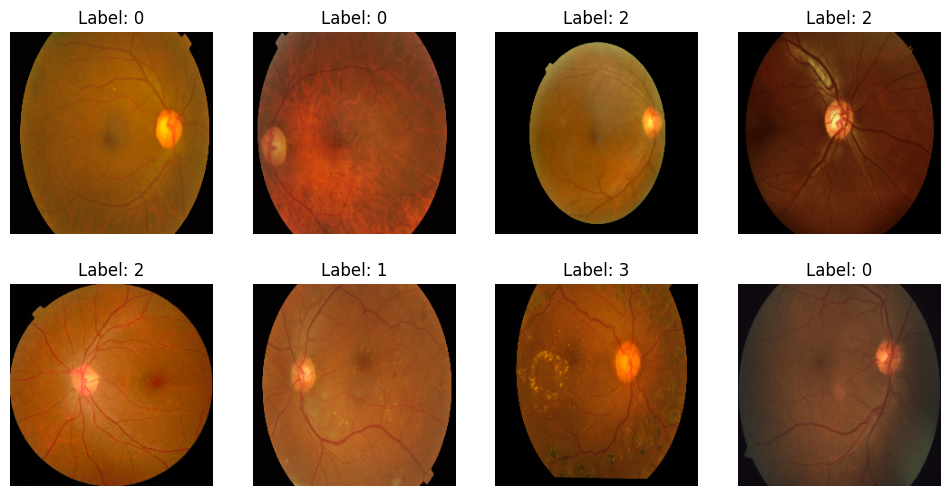

In [16]:
images = []
labels = []
for _ in range(8):
    images1, labels1 = next(iter(augmented_train_loader))
    images.append(images1[0])
    labels.append(labels1[0])

show_images(images, labels)

# 3. Model Building

In [17]:
class ConvNet(nn.Module):
    def __init__(self, input_):
        super().__init__()
        self.input_ = input_

        self.conv_block1 = nn.Sequential(
                                nn.Conv2d(self.input_, 6, 5),
                                nn.ReLU(),
                                nn.MaxPool2d(2, 2),
                                nn.Conv2d(6, 16, 5),
                                nn.ReLU(),
                                nn.MaxPool2d(2, 2),
                                # nn.Dropout2d(0.25)
                                )
        
        self.conv_block2 = nn.Sequential(
                                nn.Conv2d(16, 40, 3),
                                nn.ReLU(),
                                nn.MaxPool2d(2, 2),
                                # nn.Dropout2d(0.25)
                                )
        
        self.fc_block = nn.Sequential(
                                        nn.Linear(25*25*40, 120),
                                        nn.ReLU(),
                                        nn.Linear(120, 84),
                                        nn.ReLU(),
                                        # nn.Dropout(0.25),
                                        nn.Linear(84, 8))
        
        self.output_layer = nn.Linear(8, 5)
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(-1, 25*25*40)
        x = self.fc_block(x)   
        output = self.output_layer(x) 
        x = output.view(1, -1)
        return x

In [18]:
learning_rate = 0.000015
loss_func = nn.CrossEntropyLoss()

In [19]:
model = ConvNet(3).to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [20]:
gaussian_model = ConvNet(3).to(device)
gaussian_optimizer = optim.Adam(gaussian_model.parameters(), lr = learning_rate)

In [21]:
equi_model = ConvNet(3).to(device)
equi_optimizer = optim.Adam(equi_model.parameters(), lr = learning_rate)

In [22]:
grayscale_model = ConvNet(1).to(device)
grayscale_optimizer = optim.Adam(grayscale_model.parameters(), lr = learning_rate)

In [ ]:
center_crop_model = ConvNet(1).to(device)
center_crop_optimizer = optim.Adam(grayscale_model.parameters(), lr = learning_rate)

In [23]:
augmented_model = ConvNet(3).to(device)
augmented_optimizer = optim.Adam(augmented_model.parameters(), lr = learning_rate)

# 4. Training and Testing the Models

### 1. No Transformation Model

In [ ]:
#Training and Testing :D

loss_list = []
best_accuracy = 0.0
best_model_state = None


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)       
        labels = labels.to(device)   

        # Forward Pass
        prediction = model(images)
        loss = loss_func(prediction, labels)
        loss_list.append(loss)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 700 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps + 1}], Loss: {loss.item():.4f}')
        elif(i+1 == len(train_loader)):
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps + 1}], Loss: {loss.item():.4f}')

    print('Finished Training')

    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(5)]
        n_class_samples = [0 for i in range(5)]
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            prediction = model(image)
            _, predicted = torch.max(prediction, 1)
            n_samples += label.size(0)
            n_correct += (predicted == label).sum().item()

            if(predicted == label):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')
        if acc > best_accuracy:
            best_accuracy = acc
            best_model_state = model.state_dict()

print(f'Best Accuracy: {best_accuracy}%')
model.load_state_dict(best_model_state)

Epoch [1/40], Step [700/2930], Loss: 0.6617
Epoch [1/40], Step [1400/2930], Loss: 4.6196
Epoch [1/40], Step [2100/2930], Loss: 0.0009
Epoch [1/40], Step [2800/2930], Loss: 0.0006
Epoch [1/40], Step [2929/2930], Loss: 0.4362
Finished Training
Accuracy of the network: 68.34924965893588 %
Epoch [2/40], Step [700/2930], Loss: 0.1181
Epoch [2/40], Step [1400/2930], Loss: 0.6602
Epoch [2/40], Step [2100/2930], Loss: 0.0698
Epoch [2/40], Step [2800/2930], Loss: 1.2980
Epoch [2/40], Step [2929/2930], Loss: 0.0357
Finished Training
Accuracy of the network: 72.71487039563438 %
Epoch [3/40], Step [700/2930], Loss: 0.0155
Epoch [3/40], Step [1400/2930], Loss: 3.8465
Epoch [3/40], Step [2100/2930], Loss: 0.3492
Epoch [3/40], Step [2800/2930], Loss: 1.2265
Epoch [3/40], Step [2929/2930], Loss: 1.3790
Finished Training
Accuracy of the network: 69.98635743519782 %
Epoch [4/40], Step [700/2930], Loss: 0.0000
Epoch [4/40], Step [1400/2930], Loss: 0.0000
Epoch [4/40], Step [2100/2930], Loss: 0.6922
Epoch

<All keys matched successfully>

### 2. Gaussian Model

In [ ]:
#Training and Testing :D

loss_list = []
best_accuracy = 0.0
best_model_state = None


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(gaussian_train_loader):

        images = images.to(device)       
        labels = labels.to(device)   

        # Forward Pass
        prediction = gaussian_model(images)
        loss = loss_func(prediction, labels)
        loss_list.append(loss)
        
        # Backward and optimize
        gaussian_optimizer.zero_grad()
        loss.backward()
        gaussian_optimizer.step()

        if (i+1) % 700 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps + 1}], Loss: {loss.item():.4f}')
        elif(i+1 == len(train_loader)):
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps + 1}], Loss: {loss.item():.4f}')

    print('Finished Training')

    gaussian_model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(5)]
        n_class_samples = [0 for i in range(5)]
        for image, label in gaussian_test_loader:
            image = image.to(device)
            label = label.to(device)
            prediction = gaussian_model(image)
            _, predicted = torch.max(prediction, 1)
            n_samples += label.size(0)
            n_correct += (predicted == label).sum().item()

            if(predicted == label):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')
        if acc > best_accuracy:
            best_accuracy = acc
            best_model_state = gaussian_model.state_dict()

print(f'Best Accuracy: {best_accuracy}%')
gaussian_model.load_state_dict(best_model_state)

Epoch [1/40], Step [700/2930], Loss: 0.0005
Epoch [1/40], Step [1400/2930], Loss: 3.1808
Epoch [1/40], Step [2100/2930], Loss: 0.1185
Epoch [1/40], Step [2800/2930], Loss: 0.1269
Epoch [1/40], Step [2929/2930], Loss: 1.9552
Finished Training
Accuracy of the network: 68.62210095497953 %
Epoch [2/40], Step [700/2930], Loss: 1.5643
Epoch [2/40], Step [1400/2930], Loss: 2.0682
Epoch [2/40], Step [2100/2930], Loss: 0.0000
Epoch [2/40], Step [2800/2930], Loss: 0.9576
Epoch [2/40], Step [2929/2930], Loss: 0.0002
Finished Training
Accuracy of the network: 69.57708049113234 %
Epoch [3/40], Step [700/2930], Loss: 1.9156
Epoch [3/40], Step [1400/2930], Loss: 0.0000
Epoch [3/40], Step [2100/2930], Loss: 1.0387
Epoch [3/40], Step [2800/2930], Loss: 0.0310
Epoch [3/40], Step [2929/2930], Loss: 1.0017
Finished Training
Accuracy of the network: 70.25920873124147 %
Epoch [4/40], Step [700/2930], Loss: 0.0269
Epoch [4/40], Step [1400/2930], Loss: 0.6879
Epoch [4/40], Step [2100/2930], Loss: 0.0307
Epoch

<All keys matched successfully>

### 3. Histogram Equalized Model

In [ ]:
#Training and Testing :D

loss_list = []
best_accuracy = 0.0
best_model_state = None


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(equi_train_loader):

        images = images.to(device)       
        labels = labels.to(device)   

        # Forward Pass
        prediction = equi_model(images)
        loss = loss_func(prediction, labels)
        loss_list.append(loss)
        
        # Backward and optimize
        equi_optimizer.zero_grad()
        loss.backward()
        equi_optimizer.step()

        if (i+1) % 700 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps + 1}], Loss: {loss.item():.4f}')
        elif(i+1 == len(train_loader)):
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps + 1}], Loss: {loss.item():.4f}')

    print('Finished Training')

    equi_model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(5)]
        n_class_samples = [0 for i in range(5)]
        for image, label in equi_test_loader:
            image = image.to(device)
            label = label.to(device)
            prediction = equi_model(image)
            _, predicted = torch.max(prediction, 1)
            n_samples += label.size(0)
            n_correct += (predicted == label).sum().item()

            if(predicted == label):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')
        if acc > best_accuracy:
            best_accuracy = acc
            best_model_state = equi_model.state_dict()

print(f'Best Accuracy: {best_accuracy}%')
equi_model.load_state_dict(best_model_state)

Epoch [1/60], Step [700/2930], Loss: 1.1834
Epoch [1/60], Step [1400/2930], Loss: 2.4475
Epoch [1/60], Step [2100/2930], Loss: 1.3040
Epoch [1/60], Step [2800/2930], Loss: 3.3685
Epoch [1/60], Step [2929/2930], Loss: 0.9161
Finished Training
Accuracy of the network: 67.66712141882674 %
Epoch [2/60], Step [700/2930], Loss: 0.3948
Epoch [2/60], Step [1400/2930], Loss: 1.2765
Epoch [2/60], Step [2100/2930], Loss: 0.1426
Epoch [2/60], Step [2800/2930], Loss: 3.1519
Epoch [2/60], Step [2929/2930], Loss: 0.9077
Finished Training
Accuracy of the network: 70.25920873124147 %
Epoch [3/60], Step [700/2930], Loss: 0.0002
Epoch [3/60], Step [1400/2930], Loss: 1.4845
Epoch [3/60], Step [2100/2930], Loss: 0.0001
Epoch [3/60], Step [2800/2930], Loss: 0.0199
Epoch [3/60], Step [2929/2930], Loss: 0.4356
Finished Training
Accuracy of the network: 70.25920873124147 %
Epoch [4/60], Step [700/2930], Loss: 0.6697
Epoch [4/60], Step [1400/2930], Loss: 0.9714
Epoch [4/60], Step [2100/2930], Loss: 0.0512
Epoch

<All keys matched successfully>

### 4. Grayscale Model

In [ ]:
#Training and Testing :D

loss_list = []
best_accuracy = 0.0
best_model_state = None


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(grayscale_train_loader):

        images = images.to(device)       
        labels = labels.to(device)   

        # Forward Pass
        prediction = grayscale_model(images)
        loss = loss_func(prediction, labels)
        loss_list.append(loss)
        
        # Backward and optimize
        grayscale_optimizer.zero_grad()
        loss.backward()
        grayscale_optimizer.step()

        if (i+1) % 700 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps + 1}], Loss: {loss.item():.4f}')
        elif(i+1 == len(train_loader)):
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps + 1}], Loss: {loss.item():.4f}')

    print('Finished Training')

    grayscale_model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(5)]
        n_class_samples = [0 for i in range(5)]
        for image, label in grayscale_test_loader:
            image = image.to(device)
            label = label.to(device)
            prediction = grayscale_model(image)
            _, predicted = torch.max(prediction, 1)
            n_samples += label.size(0)
            n_correct += (predicted == label).sum().item()

            if(predicted == label):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')
        if acc > best_accuracy:
            best_accuracy = acc
            best_model_state = grayscale_model.state_dict()

print(f'Best Accuracy: {best_accuracy}%')
grayscale_model.load_state_dict(best_model_state)

Epoch [1/40], Step [700/2930], Loss: 0.4506
Epoch [1/40], Step [1400/2930], Loss: 0.0166
Epoch [1/40], Step [2100/2930], Loss: 0.0265
Epoch [1/40], Step [2800/2930], Loss: 1.4368
Epoch [1/40], Step [2929/2930], Loss: 0.9713
Finished Training
Accuracy of the network: 69.71350613915416 %
Epoch [2/40], Step [700/2930], Loss: 0.0187
Epoch [2/40], Step [1400/2930], Loss: 0.0192
Epoch [2/40], Step [2100/2930], Loss: 0.0000
Epoch [2/40], Step [2800/2930], Loss: 2.1338
Epoch [2/40], Step [2929/2930], Loss: 0.1386
Finished Training
Accuracy of the network: 70.53206002728513 %
Epoch [3/40], Step [700/2930], Loss: 0.9424
Epoch [3/40], Step [1400/2930], Loss: 0.3026
Epoch [3/40], Step [2100/2930], Loss: 0.0420
Epoch [3/40], Step [2800/2930], Loss: 2.1487
Epoch [3/40], Step [2929/2930], Loss: 0.0997
Finished Training
Accuracy of the network: 70.3956343792633 %
Epoch [4/40], Step [700/2930], Loss: 0.0045
Epoch [4/40], Step [1400/2930], Loss: 0.0044
Epoch [4/40], Step [2100/2930], Loss: 0.2490
Epoch 

<All keys matched successfully>

### 5. Center-Crop Model

In [ ]:
#Training and Testing :D

loss_list = []
best_accuracy = 0.0
best_model_state = None


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(center_cropped_train_loader):

        images = images.to(device)       
        labels = labels.to(device)   

        # Forward Pass
        prediction = center_crop_model(images)
        loss = loss_func(prediction, labels)
        loss_list.append(loss)
        
        # Backward and optimize
        center_crop_optimizer.zero_grad()
        loss.backward()
        center_crop_optimizer.step()

        if (i+1) % 700 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps + 1}], Loss: {loss.item():.4f}')
        elif(i+1 == len(train_loader)):
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps + 1}], Loss: {loss.item():.4f}')

    print('Finished Training')

    center_crop_model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(5)]
        n_class_samples = [0 for i in range(5)]
        for image, label in center_cropped_test_loader:
            image = image.to(device)
            label = label.to(device)
            prediction = center_crop_model(image)
            _, predicted = torch.max(prediction, 1)
            n_samples += label.size(0)
            n_correct += (predicted == label).sum().item()

            if(predicted == label):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')
        if acc > best_accuracy:
            best_accuracy = acc
            best_model_state = center_crop_model.state_dict()

print(f'Best Accuracy: {best_accuracy}%')
center_crop_model.load_state_dict(best_model_state)

Epoch [1/40], Step [700/2930], Loss: 1.1185
Epoch [1/40], Step [1400/2930], Loss: 0.1067
Epoch [1/40], Step [2100/2930], Loss: 0.0759
Epoch [1/40], Step [2800/2930], Loss: 2.5321
Epoch [1/40], Step [2929/2930], Loss: 1.4980
Finished Training
Accuracy of the network: 66.0300136425648 %
Epoch [2/40], Step [700/2930], Loss: 0.2825
Epoch [2/40], Step [1400/2930], Loss: 1.3533
Epoch [2/40], Step [2100/2930], Loss: 0.8002
Epoch [2/40], Step [2800/2930], Loss: 0.0171
Epoch [2/40], Step [2929/2930], Loss: 0.6395
Finished Training
Accuracy of the network: 68.62210095497953 %
Epoch [3/40], Step [700/2930], Loss: 0.4459
Epoch [3/40], Step [1400/2930], Loss: 0.0729
Epoch [3/40], Step [2100/2930], Loss: 5.1839
Epoch [3/40], Step [2800/2930], Loss: 0.0009
Epoch [3/40], Step [2929/2930], Loss: 0.0359
Finished Training
Accuracy of the network: 69.30422919508868 %
Epoch [4/40], Step [700/2930], Loss: 0.0157
Epoch [4/40], Step [1400/2930], Loss: 0.7528
Epoch [4/40], Step [2100/2930], Loss: 0.0000
Epoch 

<All keys matched successfully>

### 6. Data Augmented Model

In [ ]:
#Training and Testing :D

loss_list = []
best_accuracy = 0.0
best_model_state = None


for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(augmented_train_loader):

        images = images.to(device)       
        labels = labels.to(device)   

        # Forward Pass
        prediction = augmented_model(images)
        loss = loss_func(prediction, labels)
        loss_list.append(loss)
        
        # Backward and optimize
        augmented_optimizer.zero_grad()
        loss.backward()
        augmented_optimizer.step()

        if (i+1) % 700 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps + 1}], Loss: {loss.item():.4f}')
        elif(i+1 == len(train_loader)):
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps + 1}], Loss: {loss.item():.4f}')

    print('Finished Training')

    augmented_model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(5)]
        n_class_samples = [0 for i in range(5)]
        for image, label in augmented_test_loader:
            image = image.to(device)
            label = label.to(device)
            prediction = augmented_model(image)
            _, predicted = torch.max(prediction, 1)
            n_samples += label.size(0)
            n_correct += (predicted == label).sum().item()

            if(predicted == label):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')
        if acc > best_accuracy:
            best_accuracy = acc
            best_model_state = augmented_model.state_dict()

print(f'Best Accuracy: {best_accuracy}%')
augmented_model.load_state_dict(best_model_state)

Epoch [1/40], Training Loss: 0.8607
Accuracy of the network on test set: 72.38 %
Epoch [2/40], Training Loss: 0.7612
Accuracy of the network on test set: 73.11 %
Epoch [3/40], Training Loss: 0.7358
Accuracy of the network on test set: 74.70 %
Epoch [4/40], Training Loss: 0.7097
Accuracy of the network on test set: 72.57 %
Epoch [5/40], Training Loss: 0.6767
Accuracy of the network on test set: 74.75 %
Epoch [6/40], Training Loss: 0.6445
Accuracy of the network on test set: 74.93 %
Epoch [7/40], Training Loss: 0.6048
Accuracy of the network on test set: 74.98 %
Epoch [8/40], Training Loss: 0.5601
Accuracy of the network on test set: 76.84 %
Epoch [9/40], Training Loss: 0.5115
Accuracy of the network on test set: 77.12 %
Epoch [10/40], Training Loss: 0.4606
Accuracy of the network on test set: 76.07 %
Epoch [11/40], Training Loss: 0.4115
Accuracy of the network on test set: 77.48 %
Epoch [12/40], Training Loss: 0.3481
Accuracy of the network on test set: 77.98 %
Epoch [13/40], Training L

<All keys matched successfully>

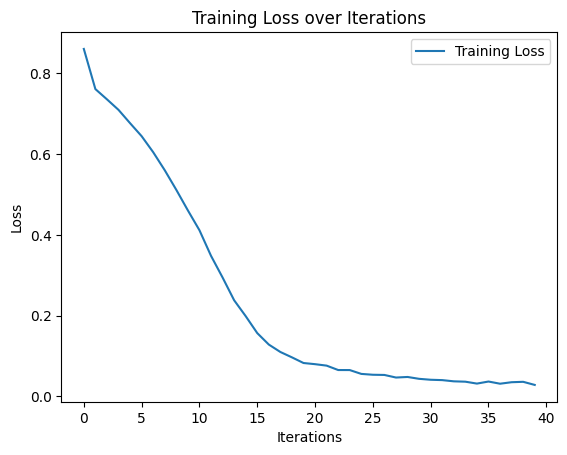

In [ ]:
plt.plot(loss_list, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Define lists to store true positives, false positives, true negatives, and false negatives for each class
TP = [0] * len(classes)
FP = [0] * len(classes)
TN = [0] * len(classes)
FN = [0] * len(classes)

# Define lists to store predictions and labels for computing accuracy, precision, and recall
all_predictions = []
all_labels = []

# Loop over the test dataset
for images, labels in augmented_test_loader:
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    predictions = augmented_model(images)
    _, predicted = torch.max(predictions, 1)

    # Update lists for computing accuracy
    all_predictions.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

    # Update TP, FP, TN, FN for each class
    for i in range(len(classes)):
        TP[i] += ((predicted == i) & (labels == i)).sum().item()
        FP[i] += ((predicted == i) & (labels != i)).sum().item()
        TN[i] += ((predicted != i) & (labels != i)).sum().item()
        FN[i] += ((predicted != i) & (labels == i)).sum().item()

# Compute accuracy
accuracy = accuracy_score(all_labels, all_predictions)

# Compute precision, recall, and F1-score for each class
precision = [TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0 for i in range(len(classes))]
recall = [TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0 for i in range(len(classes))]

# Print precision, recall, and accuracy for each class
for i, cls in enumerate(classes):
    print(f'Class: {cls}, Precision: {precision[i]}, Recall: {recall[i]}')

# Print overall accuracy
print(f'Overall Accuracy: {accuracy}')

# Alternatively, you can use sklearn's functions for computing precision, recall, and accuracy
precision_sklearn = precision_score(all_labels, all_predictions, average=None)
recall_sklearn = recall_score(all_labels, all_predictions, average=None)
accuracy_sklearn = accuracy_score(all_labels, all_predictions)

print(f'Sklearn Precision: {precision_sklearn}')
print(f'Sklearn Recall: {recall_sklearn}')
print(f'Sklearn Accuracy: {accuracy_sklearn}')

Class: 0, Precision: 0.5482233502538071, Recall: 0.5046728971962616
Class: 1, Precision: 0.657672849915683, Recall: 0.6521739130434783
Class: 2, Precision: 0.9464763603925067, Recall: 0.9654231119199272
Class: 3, Precision: 0.3147208121827411, Recall: 0.3924050632911392
Class: 4, Precision: 0.3111111111111111, Recall: 0.21705426356589147
Overall Accuracy: 0.7502274795268425
Sklearn Precision: [0.54822335 0.65767285 0.94647636 0.31472081 0.31111111]
Sklearn Recall: [0.5046729  0.65217391 0.96542311 0.39240506 0.21705426]
Sklearn Accuracy: 0.7502274795268425
